# COMP 9517 Lab01

### Import Libraries

In [122]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

## Task 1: Image average noise reduction

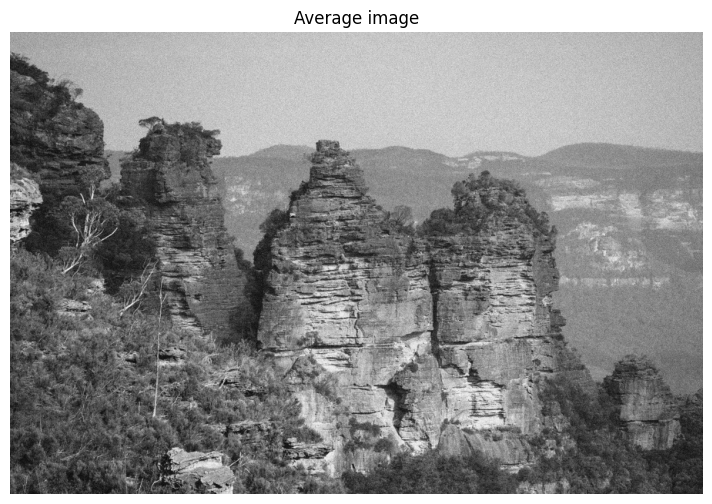

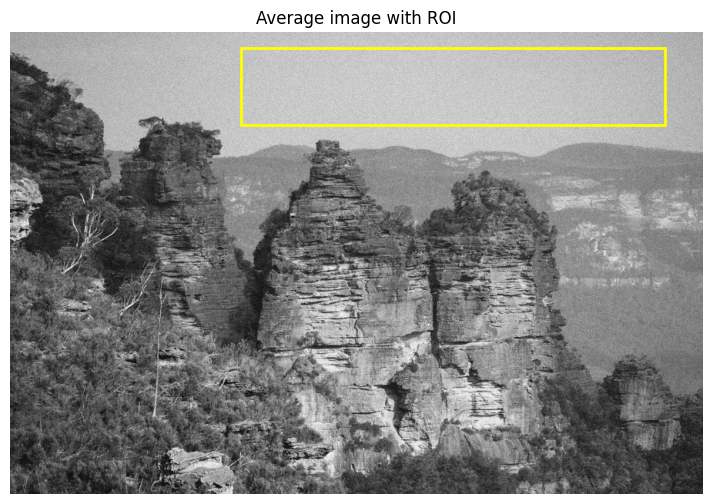

Spatial std (single image ROI): 24.84781
Spatial std (average image ROI): 9.385208
Spatial ratio (single/avg): 2.6475503
Theoretical sqrt(10): 3.1622776601683795
Mean temporal std per-pixel (single frames): 22.340408
Expected temporal std after averaging (mean_temporal_std / sqrt(N)): 7.064657416580481
Gray spatial std single: 24.84781
Gray spatial std avg: 9.388986


In [123]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# PARAMETERS
image_dir = "COMP9517_25T3_Lab1_Images"  # <-- adjust for your environment
filenames = [os.path.join(image_dir, f"Mountains{i:02d}.jpg") for i in range(1, 11)]
for f in filenames:
    if not os.path.exists(f):
        raise FileNotFoundError(f"Missing image: {f}")

# LOAD
images = []
for f in filenames:
    im = cv2.imread(f, cv2.IMREAD_COLOR)
    if im is None:
        raise RuntimeError(f"Failed to read image: {f}")
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    images.append(im_rgb.astype(np.float32))

# CHECK SHAPES
shapes = [im.shape for im in images]
if len(set(shapes)) != 1:
    raise RuntimeError(f"Image shapes differ: {set(shapes)}")

# STACK and AVERAGE
stack = np.stack(images, axis=0)   # shape (N,H,W,3)
average_image = np.mean(stack, axis=0)  # float32

# VISUALIZE average safely
avg_vis = np.clip(average_image, 0, 255).astype(np.uint8)
plt.figure(figsize=(10,6))
plt.imshow(avg_vis)
plt.title("Average image")
plt.axis('off')
plt.show()

# ROI Noise measurement in sky region
#y1, y2, x1, x2 = 0, 140, 280, 900
y1, y2, x1, x2 = 20, 120, 300, 850

# show ROI on average image
fig, ax = plt.subplots(1, figsize=(10,6))
ax.imshow(avg_vis)
rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='yellow', facecolor='none')
ax.add_patch(rect)
ax.axis('off')
plt.title("Average image with ROI")
plt.show()

# 1) Original measurement (spatial std)
single_img = images[0]
spatial_std_single = np.std(single_img[y1:y2, x1:x2, :])
spatial_std_avg = np.std(average_image[y1:y2, x1:x2, :])
print("Spatial std (single image ROI):", spatial_std_single)
print("Spatial std (average image ROI):", spatial_std_avg)
print("Spatial ratio (single/avg):", spatial_std_single / spatial_std_avg)
print("Theoretical sqrt(10):", np.sqrt(len(images)))

# 2) Better: temporal std per-pixel across frames (estimate of noise)
temporal_std_per_pixel = np.std(stack, axis=0)  # shape (H,W,3)
mean_temporal_std = np.mean(temporal_std_per_pixel[y1:y2, x1:x2, :])
expected_std_of_mean = mean_temporal_std / np.sqrt(stack.shape[0])
print("Mean temporal std per-pixel (single frames):", mean_temporal_std)
print("Expected temporal std after averaging (mean_temporal_std / sqrt(N)):", expected_std_of_mean)

# 3) Gray-level versions
single_gray = cv2.cvtColor(single_img.astype(np.uint8), cv2.COLOR_RGB2GRAY).astype(np.float32)
avg_gray = cv2.cvtColor(avg_vis, cv2.COLOR_RGB2GRAY).astype(np.float32)
print("Gray spatial std single:", np.std(single_gray[y1:y2, x1:x2]))
print("Gray spatial std avg:", np.std(avg_gray[y1:y2, x1:x2]))

# 4) Per-channel temporal std
#per_channel_temporal = np.mean(np.mean(temporal_std_per_pixel[y1:y2, x1:x2, :], axis=0), axis=0)
#print("Per-channel mean temporal std in ROI (R,G,B):", per_channel_temporal)

In [124]:
# Q1:
# If the noise is independent and identically distributed Gaussian white noise, 
# after averaging N images, the noise standard deviation is reduced to σ/√N
# Here N=10 → Theoretical reduction factor = √10 ≈ 3.16
# The standard deviation of the noise should drop by a factor of 3.16

# Q2:
# In practice, the standard deviation of pixel intensities in a sky region ≈ 2.65
# Less than 3.16, because measured spatial variation rather than pure temporal noise. 
# The images contain fixed-pattern structure, misalignment, or exposure changes
# that cannot be removed by simple averaging, so averaging performs worse.

## Task 2: Difference of Gaussians

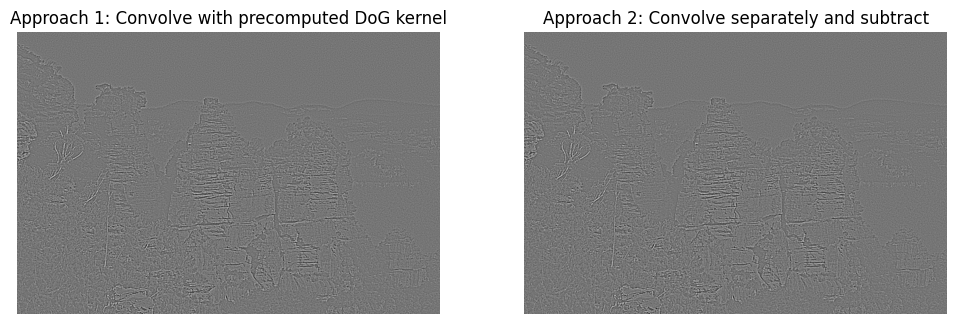

Maximum absolute difference between results: 6.639957e-05
Numerically identical within atol = 1e-6: False


In [125]:
# ==== Task2 implementation ====
import numpy as np
import cv2
import matplotlib.pyplot as plt

h1 = np.array([
    [0, 0, 0, 0, 0],
    [0, 1, 2, 1, 0],
    [0, 2, 4, 2, 0],
    [0, 1, 2, 1, 0],
    [0, 0, 0, 0, 0]
], dtype=np.float32) / 16.0

h2 = np.array([
    [1, 4, 6, 4, 1],
    [4, 16, 24, 16, 4],
    [6, 24, 36, 24, 6],
    [4, 16, 24, 16, 4],
    [1, 4, 6, 4, 1]
], dtype=np.float32) / 256.0

dog_kernel = h1 - h2  # float32

# Use float32 grayscale directly (do NOT cast to uint8 first)
img_gray = cv2.cvtColor(average_image.astype(np.float32), cv2.COLOR_RGB2GRAY)

# Explicit float32 ddepth
result1 = cv2.filter2D(img_gray, ddepth=cv2.CV_32F, kernel=dog_kernel)
filtered_h1 = cv2.filter2D(img_gray, ddepth=cv2.CV_32F, kernel=h1)
filtered_h2 = cv2.filter2D(img_gray, ddepth=cv2.CV_32F, kernel=h2)
result2 = filtered_h1 - filtered_h2

# robust normalize_for_display
def normalize_for_display(img):
    img_min, img_max = float(img.min()), float(img.max())
    if img_max - img_min < 1e-9:
        return np.full(img.shape, 128, dtype=np.uint8)
    norm = (img - img_min) / (img_max - img_min)
    return (norm * 255).astype(np.uint8)

# show
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(normalize_for_display(result1), cmap='gray'); plt.title("Approach 1: Convolve with precomputed DoG kernel"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(normalize_for_display(result2), cmap='gray'); plt.title("Approach 2: Convolve separately and subtract"); plt.axis('off')
plt.show()

# compare
diff = np.abs(result1 - result2)
print(f"Maximum absolute difference between results: {diff.max():.6e}")
print("Numerically identical within atol = 1e-6:", np.allclose(result1, result2, atol=1e-6))

In [126]:
# Answers to Task 2 questions:
# Q1: Which approach is computationally faster?
# A1: Theoretically, convolving once with the DoG kernel is cheaper (1 5×5 convolution) than
#     convolving twice and subtracting (2 5×5 convolutions). However, Approach 2 might be faster.

# Q2: Are the pixel values in the two result images exactly the same?
# A2: Theoretically yes, because of the distributive property of convolution. 
#     However, tiny differences 6.639957e-05 because of floating-point rounding errors.
#     These are visually negligible and do not affect the correctness.

## Task 3: Unsharp Masking

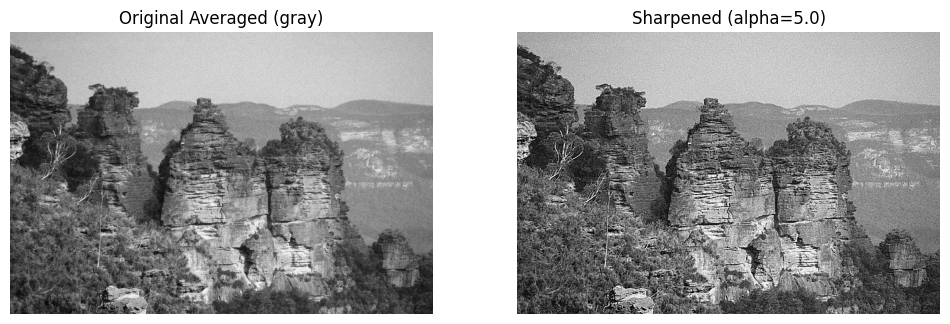

ROI gray std before: 9.385; after: 13.552; ratio(after/before) = 1.444


In [127]:
# ===== Task3 Unsharp Masking =====
import numpy as np
import cv2
import matplotlib.pyplot as plt

# assume average_image and result2 exist from previous cells
# detect grayscale:
if average_image.ndim == 2:
    img_gray = average_image.astype(np.float32)
elif average_image.ndim == 3 and average_image.shape[2] == 3:
    # check if RGB channels are identical (true grayscale stored in 3 channels)
    ch0, ch1, ch2 = average_image[...,0], average_image[...,1], average_image[...,2]
    if np.allclose(ch0, ch1) and np.allclose(ch0, ch2):
        img_gray = ch0.astype(np.float32)
    else:
        # fallback: convert to gray
        img_gray = cv2.cvtColor(average_image.astype(np.float32), cv2.COLOR_RGB2GRAY)
else:
    raise ValueError("average_image has unexpected shape: " + str(average_image.shape))

# DoG result (assumed float32 single-channel)
dog_image = result2.astype(np.float32)

# Unsharp mask
alpha = 5.0
sharpened = img_gray + alpha * dog_image  # float32 arithmetic
sharpened_clipped = np.clip(sharpened, 0.0, 255.0).astype(np.uint8)
img_gray_vis = np.clip(img_gray, 0.0, 255.0).astype(np.uint8)

# Display
plt.figure(figsize=(12,6))
plt.subplot(1,2,1); plt.imshow(img_gray_vis, cmap='gray'); plt.title("Original Averaged (gray)"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(sharpened_clipped, cmap='gray'); plt.title(f"Sharpened (alpha={alpha})"); plt.axis('off')
plt.show()

# ROI quantification
#y1, y2, x1, x2 = 0, 140, 280, 900
y1, y2, x1, x2 = 20, 120, 300, 850
roi_before = img_gray[y1:y2, x1:x2]
roi_after = sharpened[y1:y2, x1:x2]  # keep float for std
std_before = float(np.std(roi_before))
std_after = float(np.std(roi_after))
print(f"ROI gray std before: {std_before:.3f}; after: {std_after:.3f}; ratio(after/before) = {std_after/std_before:.3f}")

In [128]:
# Answers to Task 3 questions:
# Q1: In addition to edge sharpness, what else has been amplified in the output image of Task 3,
#     which we were trying to get rid of in Task 1?
# A1: Besides edges, residual high-frequency noise (sensor noise, compression artifacts, fine texture) 
#     is amplified as well — evidenced by the ROI std rising from 9.385 to 13.552 (+44.4%)

# Q2: What is the theoretical explanation for why this happens?
# A2: DoG is a high-pass operator and therefore amplifies all rapid intensity changes in the
#     high-frequency band. This is the inherent trade-off of sharpening; mitigations include 
#     thresholding the DoG, denoising before sharpening, or sharpening only the luminance channel.